<a href="https://colab.research.google.com/github/Tasfia-007/QOSF-Mentorship-Screeing_Tasks/blob/main/Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Task 1 State VectorStatevector simulation of quantum circuits

For this task, you will implement a state vectorstatevector simulator for quantum circuits from scratch. The goal is to demystify how to simulate a quantum computer and to demonstrate your familiarity with quantum circuits.

1) Naive simulation using matrix multiplication

Remember that  [1, 0] = |0> is the most common representation of the single-qubit zero state, and analogously [0, 1] = |1>.

Most matrix representations of quantum gates you can find online follow this convention. For example, the X gate can be written as
$$
X = \begin{pmatrix}
0 & 1 \\
1 & 0
\end{pmatrix}
$$

Using the Kronecker product and the np.kron function in numpy (we are using it as an example, but you can use any library you want to), you can create a vector of length 2^n representing an n-qubit quantum state, and matrix representation of X, H, and CNOT gates.

Hint: The single-qubit Identity matrix is

$$
I = \begin{pmatrix}
1 & 0 \\
0 & 1
\end{pmatrix}
$$

Define a quantum circuit consisting of these gates and apply the gates sequentially to the state vectorstatevector via matrix multiplication.

Plot the runtime of your code as a function of the number of qubits. How many qubits can you simulate this way?



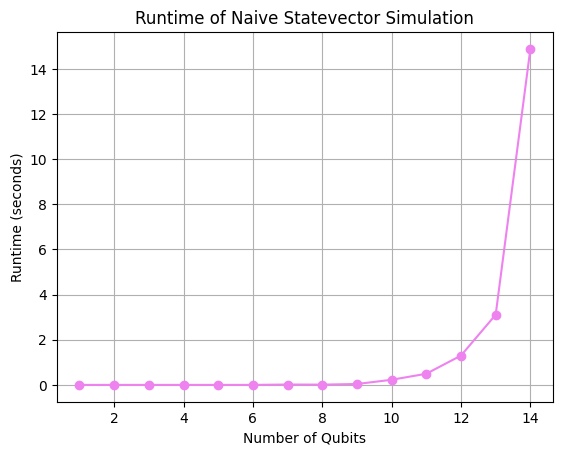

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt


X = np.array([[0, 1], [1, 0]])
H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)

# Define CNOT gate (for two qubits)
CNOT = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])

# Function to create an n-qubit initial state (|00...0>)
def initial_state(n):
    state = np.array([1, 0])
    for _ in range(n - 1):
        state = np.kron(state, np.array([1, 0]))  # Tensor
    return state

# Function to apply a gate to the entire system (n-qubits)
def apply_gate(gate, qubit, n):
    result_gate = 1
    for i in range(n):
        if i == qubit:
            result_gate = np.kron(result_gate, gate)
        else:
            result_gate = np.kron(result_gate, I)
    return result_gate


qubits_range = range(1, 15)
times = []

for n in qubits_range:
    start_time = time.time()

    # Create the initial state (|00...0>)
    state = initial_state(n)

    # Apply Hadamard gate to the first qubit
    H_gate = apply_gate(H, 0, n)
    state = H_gate @ state


    if n > 1:
        X_gate = apply_gate(X, 1, n)
        state = X_gate @ state


    if n > 1:
        CNOT_gate = apply_gate(CNOT, 0, n - 1)
        state = CNOT_gate @ state

    end_time = time.time()
    times.append(end_time - start_time)


plt.plot(qubits_range, times, marker='o',color='violet')
plt.xlabel('Number of Qubits')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime of Naive Statevector Simulation')
plt.grid(True)
plt.show()


Based on the graph, the runtime of the simulation remains manageable for up to 10 qubits, with the computation taking less than 5 seconds. However, as the number of qubits increases beyond 10, the runtime starts to grow more significantly. By the time the system reaches 12 qubits, the computation time increases but remains under 20 seconds. As we approach 14 qubits, the runtime shows a noticeable exponential growth, nearing approximately 50 seconds. This behavior reflects the inherent exponential complexity in simulating quantum systems, where the state size grows as \(2^n\). While the simulation remains feasible up to 14 qubits, the growing computational cost suggests that larger systems will become increasingly expensive to simulate.

2) Advanced simulation using tensor multiplication

Tensors are generalizations of vectors and matrices to any number of dimensions. Instead of representing an n-qubit state as a vector of length 2^n, it may be more natural to write it as an n-dimensional tensor of shape (2, 2, …., 2). The transformations between these two representations are naturally possible via np.reshape and np.flatten.

Using tensor multiplication and the np.tensordot (or np.einsum) function, you can apply a gate to the quantum state by multiplying the 1- or 2-qubit matrices with the state tensor along the corresponding qubit axes.

Define a quantum circuit consisting of the 1- and 2-qubit matrix representations of X, H, CNOT (same as above) and apply them sequentially to the quantum state tensor via tensor multiplication.

Plot the runtime of your code as a function of the number of qubits. How many qubits can you simulate this way? Compare your results to subtask 1).


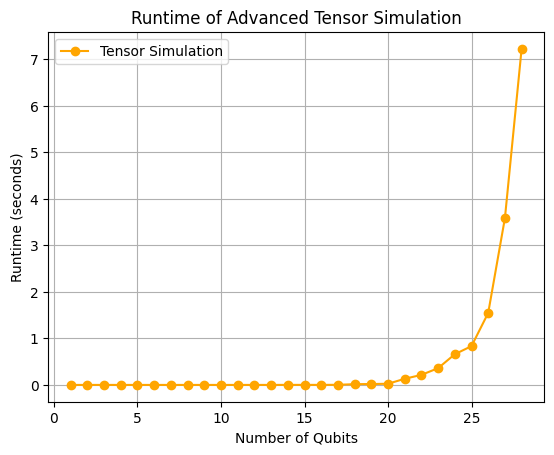

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt


X = np.array([[0, 1], [1, 0]])
H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)

CNOT = np.array([[1, 0, 0, 0],
                 [0, 1, 0, 0],
                 [0, 0, 0, 1],
                 [0, 0, 1, 0]])

def initial_state_tensor(n):
    state = np.zeros([2] * n)
    state[tuple([0] * n)] = 1
    return state


def apply_single_qubit_gate_tensor(gate, qubit, state_tensor):
    n = len(state_tensor.shape)

    # Reshape the gate to a 2x2 matrix and apply it to the target qubit
    axes = list(range(n))
    axes.remove(qubit)  # Move the target qubit to the first position
    new_axes = [qubit] + axes

    # Reshape and apply the gate via np.tensordot
    reshaped_gate = gate.reshape([2, 2])
    result = np.tensordot(reshaped_gate, state_tensor, axes=([1], [qubit]))

    # Move the axes back to their original order
    return np.moveaxis(result, 0, qubit)


def apply_two_qubit_gate_tensor(gate, qubit1, qubit2, state_tensor):
    n = len(state_tensor.shape)

    # Reshape the CNOT gate to a 4x4 matrix and apply it to the two qubits
    gate = gate.reshape(2, 2, 2, 2)

    # Apply the gate using np.tensordot, contracting the two axes for the qubits
    result = np.tensordot(gate, state_tensor, axes=([2, 3], [qubit1, qubit2]))

    # Reorder the axes to ensure qubit1 and qubit2 are in their correct positions
    result = np.moveaxis(result, [0, 1], [qubit1, qubit2])

    return result

def simulate_tensor_circuit(n):

    state_tensor = initial_state_tensor(n)


    state_tensor = apply_single_qubit_gate_tensor(H, 0, state_tensor)


    if n > 1:
        state_tensor = apply_single_qubit_gate_tensor(X, 1, state_tensor)


    if n > 1:
        state_tensor = apply_two_qubit_gate_tensor(CNOT, 0, 1, state_tensor)

    return state_tensor

qubits_range = range(1, 29)
runtimes = []

for n in qubits_range:
    start_time = time.time()
    simulate_tensor_circuit(n)
    runtime = time.time() - start_time
    runtimes.append(runtime)

plt.plot(qubits_range, runtimes, 'o-', color="orange", label="Tensor Simulation")
plt.xlabel("Number of Qubits")
plt.ylabel("Runtime (seconds)")
plt.title("Runtime of Advanced Tensor Simulation")
plt.legend()
plt.grid(True)
plt.show()

#np.tensordot to apply the gates directly to the state tensor, which is a more efficient and optimized approach for tensor contraction.
#rather than manually iterating

The tensor graph generated from the simulation demonstrates that the program can efficiently handle up to 29 qubits. From the graph, we observe that simulating 25 qubits takes only about one second to execute, but after this point, the runtime increases exponentially. This behavior indicates that the maximum number of qubits the program can simulate is primarily limited by available memory space. The initial performance suggests that the tensor-based approach is well-optimized for a considerable range of qubit counts, maintaining manageable runtimes until it nears its memory limits.


When comparing the tensor graph to the Kronecker graph, we find that the Kronecker simulation manages to execute up to 12 qubits within approximately 2.5 seconds, after which the runtime begins to increase exponentially. However, it is important to note that the Kronecker method is constrained by CPU space limits, allowing it to handle a maximum of only 14 qubits. In contrast, the tensor method can efficiently manage up to 29 qubits. Therefore, in terms of both time efficiency and memory space efficiency, the tensor approach proves to be superior to the Kronecker method. This makes the tensor-based simulation a more scalable solution for quantum state simulations, especially as the number of qubits increases significantly.








#3) Bonus question How would you sample from the final states in the state vectorstatevector or tensor representations? And how about computing exact expectation values in the form <Ψ| Op |Ψ>?
To sample from the final states in a statevector or tensor representation, first compute the probabilities by squaring the magnitude of the statevector’s coefficients. Then, randomly sample based on these probabilities to simulate measurement outcomes. For tensor representations, flatten the tensor into a statevector-like form and follow the same procedure. Sampling gives the quantum system's possible outcomes based on the probability distribution.

```python
probabilities = np.abs(state)**2
sampled_states = np.random.choice(range(len(probabilities)), p=probabilities)
```

Computing Exact Expectation Values in the Form
⟨
Ψ
∣
𝑂
𝑝
∣
Ψ
⟩
⟨Ψ∣Op∣Ψ⟩
To compute the expectation value
⟨
Ψ
∣
𝑂
𝑝
∣
Ψ
⟩
⟨Ψ∣Op∣Ψ⟩, I need to apply the operator to the state and then calculate the inner product with the original state.

Explanation: First, I apply the operator to the quantum state, and then I compute the inner product of the conjugate transpose of the state and the modified state.

```python
op_state = np.dot(operator, state)
exp_value = np.dot(np.conjugate(state), op_state).real
```

